In [1]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [2]:
# Import all packages

import numpy as np
import itkConfig
itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [7]:
# Helper Functions

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [19]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [75]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [76]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [77]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [5]:
sample = vtk.vtkPolyDataPointSampler()
sample.SetInputData(m1)
sample.SetGenerateEdgePoints(0)
sample.SetGenerateInteriorPoints(0)
sample.SetPointGenerationModeToRegular()
sample.SetDistance(0.1)
sample.Update()

sampled_points = sample.GetOutput()

print(m1.GetNumberOfPoints())
print(sampled_points.GetNumberOfPoints())

2209640
2209640


In [15]:
vtk_data_array = numpy_support.numpy_to_vtk(num_array=as_numpy_sampled,
                                            deep=True,
                                            array_type=vtk.VTK_FLOAT)
points2 = vtk.vtkPoints()
points2.SetData(vtk_data_array)

In [16]:
poly1 = vtk.vtkPolyData()
poly1.SetPoints(points2)

In [24]:
print(as_numpy_sampled.shape)
print(as_numpy_sampled)

(10000, 3)
[[ -19.032843  -62.61089    59.35268 ]
 [-102.698235  -36.72439   102.16699 ]
 [ -62.66175  -118.70344   112.004196]
 ...
 [ -72.941345 -124.75717    79.54381 ]
 [ -48.884876  -20.545244   62.336174]
 [ -86.15137  -143.80577    69.43055 ]]


In [21]:
f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m1)
f.Update()
m1d = f.GetOutput()

f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m2)
f.Update()
m2d = f.GetOutput()

print(m1d.GetNumberOfPoints())
print(m2d.GetNumberOfPoints())

242246
439173


In [14]:
number_of_rows = 10000

random_indices = np.random.choice(as_numpy.shape[0], 
                                  size=number_of_rows, 
                                  replace=False)
as_numpy_sampled = as_numpy[random_indices, :]

print(as_numpy_sampled.shape)

(10000, 3)


In [ ]:
itkwidgets.view(geometries=[fixedMesh, movingMesh])

In [32]:
# Perform RANSAC ICP

def ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergance_value):
    all_points1 = itk.array_from_vector_container(movingMesh.GetPoints())
    all_points2 = itk.array_from_vector_container(fixedMesh.GetPoints())
    
    # Create Meshes with reduced number of points
    mesh_fixed  = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()
    
    random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    p1 = all_points1[random_indices, :]
    mesh_fixed.SetPoints(itk.vector_container_from_array(p1.flatten()))
    
    random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    p2 = all_points2[random_indices, :]
    mesh_moving.SetPoints(itk.vector_container_from_array(p2.flatten()))
    
    best_score = 100000
    best_result = None
    best_transform = None
    
    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    else:
        TransformType = itk.ScaleTransform[itk.D, 3]
    transform = TransformType.New()
    transform.SetIdentity()
    
    e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
    
    # For reproduciblity
    np.random.seed(5)
    for i in range(number_of_iterations):
        random_indices = np.random.choice(all_points1.shape[0], size=number_of_ransac_points)
        p1 = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0], size=number_of_ransac_points)
        p2 = all_points2[random_indices, :]

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 10 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        current_transform    = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(mesh_moving, transform=current_transform)

        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        
        if current_value < best_score:
            best_score     = current_value
            best_result    = itk_transformed_mesh
            best_transform = current_transform

        if convergance_value > 0 and best_score < convergance_value:
            break
    
    print('Best Score ', best_score)
    itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=best_transform)
    return itk_transformed_mesh


#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

movingMesh = itk.meshread('movingMesh.vtk')
fixedMesh  = itk.meshread('fixedMesh.vtk')

number_of_iterations    = 2000
number_of_ransac_points = 250
mesh_sub_sample_points  = 5000
convergence_value       = 6
transform_type          = 0

import time
start_time = time.time()
itk_transformed_mesh = ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
itk.meshwrite(itk_transformed_mesh, 'ransacICPResult1.vtk')
end_time = time.time()

print(end_time - start_time)
# itk_transformed_mesh = itk.meshread('ransacICPResult1.vtk')
# number_of_iterations    = 100
# number_of_ransac_points = 1000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 0
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult2.vtk')


# number_of_iterations    = 100
# number_of_ransac_points = 10000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 1
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult3.vtk')

Best Score  13.128441318309916
65.535471200943


In [ ]:
# Perform Scale Transform

mesh_sub_sample_points = 10000

fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)
movingMesh = itk.meshread('movingMesh.vtk', itk.D)

ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
p1 = all_points1[random_indices, :]

random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
p2 = all_points2[random_indices, :]

ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))


    
TransformType = itk.ScaleTransform[itk.D, 3]
        
transform = TransformType.New()
transform.SetIdentity()

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(movingMesh)
metric.SetFixedPointSet(fixedMesh)
metric.SetMovingTransform(transform)
metric.Initialize()

optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
optimizer.SetNumberOfIterations(10)
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )
optimizer.SetMetric(metric)
optimizer.StartOptimization()

current_transform    = metric.GetTransform()
itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=current_transform)

In [ ]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    #all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
    #all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

    #random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    #p1 = all_points1[random_indices, :]

    #random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    #p2 = all_points2[random_indices, :]

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization

        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[
            itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits(0.5)
        optimizer.SetMinimumConvergenceValue(0.0)
        optimizer.SetConvergenceWindowSize(10)
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        #optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
        #         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        #         optimizer.SetNumberOfIterations(200)
        #         optimizer.SetLearningRate(0.1)
        #         optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        #         optimizer.SetMinimumConvergenceValue( 0.0 )
        #         optimizer.SetConvergenceWindowSize( 200 )
        #         optimizer.SetMetric(metric)
        #         optimizer.StartOptimization()

        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshAllPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))

    return final_result


import time

#movingMesh = itk.meshread('movingMesh.vtk')
#fixedMesh  = itk.meshread('fixedMesh.vtk')


def subsample_points(inputmesh, mesh_sub_sample_points):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)

    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled


#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

#for k in range(5):
number_of_iterations = 500
number_of_ransac_points = 500
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2

movingMesh = readvtk('movingMesh.vtk')
fixedMesh = readvtk('fixedMesh.vtk')

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())
movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points)
fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)
print(movingMeshAllPoints.shape)

start_time = time.time()
itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)

itk_transformed_mesh = itk.meshread('movingMesh.vtk')

#itk_transformed_mesh = itk.Mesh.D3.New()
itk_transformed_mesh.SetPoints(
    itk.vector_container_from_array(itk_transformed_points.flatten()))

w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(itk_transformed_mesh)
w1.Update()


fixedMesh = itk.meshread('fixedMesh.vtk')
e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

# number_of_iterations    = 50
# number_of_ransac_points = 20000
# mesh_sub_sample_points  = 50000
# convergence_value       = 3pran

# transform_type          = 0

# start_time = time.time()
# itk_transformed_mesh = ransac_icp_parallel(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# end_time = time.time()
# print(end_time - start_time)

# w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
# w1.SetFileName('ransacICPResult2.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(itk_transformed_mesh)
# w1.Update()

In [6]:
mesh_fixed = itk.Mesh.D3.New()#itk.meshread('fixedMesh.vtk', itk.D)
itk_transformed_mesh = itk.Mesh.D3.New()#itk.meshread('ransacICPResult2_b.vtk', itk.D)

mesh_fixed.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
itk_transformed_mesh.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

print(e_metric.GetValue())

5.559841893722685


In [ ]:
itkwidgets.view(point_sets=[mesh_fixed, itk_transformed_mesh])

In [33]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m3 = readvtk('ransacICPResult2_b_check.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/TargetPointcloud.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SourcePointcloud.vtk')

#m1 = readply('USNM252577-Cranium_8.ply')
#m2 = readply('USNM145303-Cranium_9.ply')
#m3 = readply('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.ply')

#m3 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')

#m1 = readply('/data/Apedata/apedata/experiment/USNM145303-Cranium_1.ply')
#m2 = readply('/data/Apedata/apedata/experiment/USNM252577-Cranium.ply')
#m3 = readvtk('/data/Apedata/apedata/experiment/WarpedSourceMesh.vtk')

#print(m1.GetNumberOfPoints())
#print(m2.GetNumberOfPoints())
#print(m3.GetNumberOfPoints())
#print(m4.GetNumberOfPoints())

#view(point_sets=[movingMeshPoints, fixedMeshPoints])
#view(geometries=[m1, m2, m4])
#view(geometries=[m1, m2, m3, m4])
#view(geometries=[m1, m2, m3])
view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [16]:
itkwidgets.view(point_sets=[fixedMeshPoints, movingMeshPoints])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [32]:
# Expectation Based PointSetToPointSetMetricv4 Registration

import copy

imageDiagonal = 50

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# Read the meshes
fixedMesh  = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
movingMesh = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

movingMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData()))

fixedMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    fixedMesh.GetPoints().GetData()))

print(movingMeshAllPoints.shape)
print(fixedMeshAllPoints.shape)

movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points)
fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)



# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))



# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()
bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.2 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.2 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.2 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()



# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



# Registration Loop
numOfIterations = 5000
maxStep = 1
learningRate = 1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2.0)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()


# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingPS.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingPS.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())


# Write the mesh to disk
movingMeshITK = itk.meshread('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk', itk.D)
numberOfPoints = movingMeshITK.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))
    

w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
w1.SetFileName('ransacICPResult2_b_check.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMeshITK)
w1.Update()

(3277652, 3)
(2209640, 3)
(5000, 3)
(5000, 3)
Spacing  5.009083467811252
minBounds  [-139.50758362 -195.52449036   29.13595581]
maxBounds  [-20.70505333   2.41165018 126.26750183]
Metric Created
Metric: -0.13087488
Metric: -0.13105133
Metric: -0.1312206
Metric: -0.13138198
Metric: -0.13153238
Metric: -0.13168856
Metric: -0.13185599
Metric: -0.13204551
Metric: -0.13228609
Metric: -0.13260077
Metric: -0.13311025
Metric: -0.13356625
Metric: -0.13404622
Metric: -0.13446668
Metric: -0.13504534
Metric: -0.13561043
Metric: -0.13607347
Metric: -0.13667375
Metric: -0.13708468
Metric: -0.13765789
Metric: -0.13808828
Metric: -0.13867992
Metric: -0.13919993
Metric: -0.1397257
Metric: -0.1403989
Metric: -0.14099757
Metric: -0.1416138
Metric: -0.14220259
Metric: -0.14278678
Metric: -0.14343678
Metric: -0.14411258
Metric: -0.14488243
Metric: -0.14553884
Metric: -0.14621013
Metric: -0.14675311
Metric: -0.14724403
Metric: -0.14788771
Metric: -0.1485547
Metric: -0.14925514
Metric: -0.14991545
Metric: -0

Metric: -0.2228243
Metric: -0.22298578
Metric: -0.22314428
Metric: -0.22330075
Metric: -0.22345571
Metric: -0.2236094
Metric: -0.22376249
Metric: -0.22391451
Metric: -0.22406563
Metric: -0.22421539
Metric: -0.22436431
Metric: -0.22451313
Metric: -0.22466136
Metric: -0.22480896
Metric: -0.22495571
Metric: -0.22510175
Metric: -0.22524769
Metric: -0.22539365
Metric: -0.22553984
Metric: -0.2256855
Metric: -0.22583118
Metric: -0.22597686
Metric: -0.22612287
Metric: -0.22626925
Metric: -0.22641555
Metric: -0.22656229
Metric: -0.2267116
Metric: -0.22686104
Metric: -0.2270107
Metric: -0.22716056
Metric: -0.22731059
Metric: -0.22746128
Metric: -0.22761213
Metric: -0.22776308
Metric: -0.22791415
Metric: -0.22806519
Metric: -0.2282145
Metric: -0.22836414
Metric: -0.22851491
Metric: -0.22866638
Metric: -0.22881879
Metric: -0.22897218
Metric: -0.22912619
Metric: -0.22928038
Metric: -0.2294363
Metric: -0.22959273
Metric: -0.22974803
Metric: -0.22990358
Metric: -0.23005888
Metric: -0.23021386
Metric:

Metric: -0.26932113
Metric: -0.26938957
Metric: -0.26946037
Metric: -0.26953276
Metric: -0.26960507
Metric: -0.26967752
Metric: -0.26975105
Metric: -0.26982442
Metric: -0.26989764
Metric: -0.26997082
Metric: -0.27004476
Metric: -0.27011771
Metric: -0.27019006
Metric: -0.27026227
Metric: -0.27033576
Metric: -0.27040919
Metric: -0.27048247
Metric: -0.27055763
Metric: -0.27063438
Metric: -0.27071402
Metric: -0.27079626
Metric: -0.27087993
Metric: -0.27096576
Metric: -0.27105381
Metric: -0.27114285
Metric: -0.27123513
Metric: -0.27132827
Metric: -0.27142069
Metric: -0.27151095
Metric: -0.2715985
Metric: -0.27168401
Metric: -0.27176819
Metric: -0.27185117
Metric: -0.27193339
Metric: -0.27201294
Metric: -0.27209037
Metric: -0.27216482
Metric: -0.27223761
Metric: -0.27230613
Metric: -0.27237419
Metric: -0.27244139
Metric: -0.27251007
Metric: -0.27257824
Metric: -0.27264529
Metric: -0.27271087
Metric: -0.27277665
Metric: -0.2728412
Metric: -0.2729056
Metric: -0.27296944
Metric: -0.27303396
Met

Metric: -0.29547112
Metric: -0.29552444
Metric: -0.29557892
Metric: -0.29562989
Metric: -0.29568358
Metric: -0.29573706
Metric: -0.29579138
Metric: -0.29584611
Metric: -0.29590018
Metric: -0.29595549
Metric: -0.2960063
Metric: -0.29606257
Metric: -0.29611744
Metric: -0.29617347
Metric: -0.29622876
Metric: -0.29628543
Metric: -0.29634242
Metric: -0.29639701
Metric: -0.29645246
Metric: -0.29650903
Metric: -0.296566
Metric: -0.29662025
Metric: -0.29667732
Metric: -0.29673501
Metric: -0.29680087
Metric: -0.29685472
Metric: -0.29691691
Metric: -0.29697178
Metric: -0.29703276
Metric: -0.29708824
Metric: -0.29714848
Metric: -0.29720429
Metric: -0.29726126
Metric: -0.29731792
Metric: -0.29737568
Metric: -0.29743548
Metric: -0.2974928
Metric: -0.29754992
Metric: -0.29760327
Metric: -0.29765975
Metric: -0.2977149
Metric: -0.29777482
Metric: -0.29783196
Metric: -0.29789668
Metric: -0.2979576
Metric: -0.29801872
Metric: -0.29807874
Metric: -0.29814249
Metric: -0.29820362
Metric: -0.29826823
Metric

Metric: -0.30840993
Metric: -0.30842654
Metric: -0.30844104
Metric: -0.30845674
Metric: -0.30847206
Metric: -0.30848954
Metric: -0.30850516
Metric: -0.30852165
Metric: -0.3085381
Metric: -0.30855612
Metric: -0.30857113
Metric: -0.30858888
Metric: -0.3086046
Metric: -0.30862298
Metric: -0.30863975
Metric: -0.30865707
Metric: -0.30867319
Metric: -0.30869227
Metric: -0.30871025
Metric: -0.30872803
Metric: -0.30874429
Metric: -0.30876525
Metric: -0.30878361
Metric: -0.30880434
Metric: -0.30882134
Metric: -0.30884054
Metric: -0.3088578
Metric: -0.30887524
Metric: -0.30889235
Metric: -0.30891097
Metric: -0.30892799
Metric: -0.30894429
Metric: -0.3089625
Metric: -0.30897903
Metric: -0.30899452
Metric: -0.30901037
Metric: -0.30902484
Metric: -0.30904197
Metric: -0.30905725
Metric: -0.30907366
Metric: -0.30908922
Metric: -0.30910529
Metric: -0.30912265
Metric: -0.30913827
Metric: -0.3091564
Metric: -0.30917442
Metric: -0.30919087
Metric: -0.30920764
Metric: -0.3092245
Metric: -0.3092392
Metric:

Metric: -0.31306646
Metric: -0.31306952
Metric: -0.3130752
Metric: -0.31307852
Metric: -0.31308334
Metric: -0.31308785
Metric: -0.31309273
Metric: -0.31309746
Metric: -0.31310206
Metric: -0.31310648
Metric: -0.31311112
Metric: -0.31311599
Metric: -0.31312152
Metric: -0.31312574
Metric: -0.31313131
Metric: -0.31313728
Metric: -0.31314293
Metric: -0.31314803
Metric: -0.31315375
Metric: -0.31316062
Metric: -0.31316589
Metric: -0.31317121
Metric: -0.31317705
Metric: -0.31318299
Metric: -0.3131889
Metric: -0.3131942
Metric: -0.31319971
Metric: -0.31320492
Metric: -0.31320939
Metric: -0.31321662
Metric: -0.31322004
Metric: -0.31322764
Metric: -0.31323094
Metric: -0.31323771
Metric: -0.31324114
Metric: -0.31324513
Metric: -0.31325138
Metric: -0.31325396
Metric: -0.31326105
Metric: -0.31326375
Metric: -0.31327043
Metric: -0.31327573
Metric: -0.31328157
Metric: -0.31328425
Metric: -0.31329064
Metric: -0.31329588
Metric: -0.31330186
Metric: -0.31330504
Metric: -0.31331188
Metric: -0.31331402
Met

Metric: -0.31500444
Metric: -0.31500834
Metric: -0.31501254
Metric: -0.31501676
Metric: -0.3150212
Metric: -0.31502512
Metric: -0.31502906
Metric: -0.31503247
Metric: -0.31503554
Metric: -0.31503926
Metric: -0.31504293
Metric: -0.31504719
Metric: -0.31505113
Metric: -0.31505524
Metric: -0.3150595
Metric: -0.3150639
Metric: -0.31506806
Metric: -0.31507212
Metric: -0.31507571
Metric: -0.31507947
Metric: -0.31508324
Metric: -0.31508664
Metric: -0.31509131
Metric: -0.31509486
Metric: -0.31509892
Metric: -0.31510282
Metric: -0.31510707
Metric: -0.31511113
Metric: -0.3151156
Metric: -0.31511996
Metric: -0.31512448
Metric: -0.315129
Metric: -0.31513299
Metric: -0.31513709
Metric: -0.31514186
Metric: -0.3151464
Metric: -0.31515089
Metric: -0.31515526
Metric: -0.31515947
Metric: -0.31516363
Metric: -0.31516856
Metric: -0.31517346
Metric: -0.31517843
Metric: -0.31518288
Metric: -0.31518693
Metric: -0.31519264
Metric: -0.31519384
Metric: -0.31519879
Metric: -0.31520272
Metric: -0.31520653
Metric:

Metric: -0.31699861
Metric: -0.31699994
Metric: -0.31700757
Metric: -0.31701155
Metric: -0.31701824
Metric: -0.31702345
Metric: -0.31702868
Metric: -0.31703447
Metric: -0.31703974
Metric: -0.31704563
Metric: -0.31705008
Metric: -0.31705639
Metric: -0.31706154
Metric: -0.31706685
Metric: -0.31707241
Metric: -0.31707864
Metric: -0.31708291
Metric: -0.31708915
Metric: -0.31709513
Metric: -0.31710071
Metric: -0.31710454
Metric: -0.3171111
Metric: -0.3171164
Metric: -0.31712173
Metric: -0.31712575
Metric: -0.31713222
Metric: -0.31713644
Metric: -0.31714337
Metric: -0.31715064
Metric: -0.31715648
Metric: -0.3171636
Metric: -0.31716901
Metric: -0.31717573
Metric: -0.31718032
Metric: -0.31718654
Metric: -0.31719166
Metric: -0.31719763
Metric: -0.31720211
Metric: -0.31720843
Metric: -0.31721253
Metric: -0.31722051
Metric: -0.31722674
Metric: -0.31723425
Metric: -0.31723857
Metric: -0.31724514
Metric: -0.31725066
Metric: -0.31725778
Metric: -0.31726301
Metric: -0.31726996
Metric: -0.31727408
Met

Metric: -0.31952714
Metric: -0.31953349
Metric: -0.31954056
Metric: -0.31954696
Metric: -0.31955427
Metric: -0.31956124
Metric: -0.31956809
Metric: -0.31957456
Metric: -0.31958159
Metric: -0.31958792
Metric: -0.31959519
Metric: -0.3196015
Metric: -0.31960897
Metric: -0.31961551
Metric: -0.31962417
Metric: -0.31963168
Metric: -0.31963905
Metric: -0.31964575
Metric: -0.3196528
Metric: -0.31966019
Metric: -0.31966679
Metric: -0.31967467
Metric: -0.31968167
Metric: -0.31968905
Metric: -0.31969558
Metric: -0.31970221
Metric: -0.31970929
Metric: -0.3197166
Metric: -0.31972438
Metric: -0.31973144
Metric: -0.31973867
Metric: -0.31974432
Metric: -0.31975098
Metric: -0.31975818
Metric: -0.31976487
Metric: -0.31977312
Metric: -0.31978011
Metric: -0.31978803
Metric: -0.31979649
Metric: -0.31980246
Metric: -0.31981033
Metric: -0.31981757
Metric: -0.31982577
Metric: -0.31983318
Metric: -0.3198402
Metric: -0.31984688
Metric: -0.31985461
Metric: -0.31986148
Metric: -0.31987043
Metric: -0.31987603
Metr

Metric: -0.32280456
Metric: -0.3228195
Metric: -0.32281619
Metric: -0.32283094
Metric: -0.32282745
Metric: -0.32284215
Metric: -0.32283805
Metric: -0.32285228
Metric: -0.32284855
Metric: -0.32286306
Metric: -0.32286056
Metric: -0.32287663
Metric: -0.32287303
Metric: -0.32288807
Metric: -0.3228838
Metric: -0.32289974
Metric: -0.32289432
Metric: -0.3229041
Metric: -0.32290467
Metric: -0.32291483
Metric: -0.32291612
Metric: -0.32292584
Metric: -0.32292813
Metric: -0.32293769
Metric: -0.32293981
Metric: -0.32294893
Metric: -0.32295129
Metric: -0.32296006
Metric: -0.32296155
Metric: -0.32297103
Metric: -0.32297203
Metric: -0.32298121
Metric: -0.32298266
Metric: -0.32299173
Metric: -0.32299303
Metric: -0.32300274
Metric: -0.32300339
Metric: -0.32301252
Metric: -0.32301392
Metric: -0.32302351
Metric: -0.32302435
Metric: -0.32303355
Metric: -0.32303443
Metric: -0.32304345
Metric: -0.32304422
Metric: -0.32305504
Metric: -0.32305575
Metric: -0.32306581
Metric: -0.32306609
Metric: -0.32307572
Met

Metric: -0.32481208
Metric: -0.32482248
Metric: -0.32482189
Metric: -0.32483205
Metric: -0.32483264
Metric: -0.32484298
Metric: -0.32484411
Metric: -0.32485384
Metric: -0.32485478
Metric: -0.32486386
Metric: -0.32486487
Metric: -0.32487392
Metric: -0.32487481
Metric: -0.32488363
Metric: -0.324884
Metric: -0.32489269
Metric: -0.32489308
Metric: -0.32490183
Metric: -0.32490171
Metric: -0.32491074
Metric: -0.32491137
Metric: -0.3249206
Metric: -0.3249201
Metric: -0.32492964
Metric: -0.32492828
Metric: -0.32493837
Metric: -0.32493744
Metric: -0.32494749
Metric: -0.32494585
Metric: -0.32495553
Metric: -0.32495452
Metric: -0.32496502
Metric: -0.32496379
Metric: -0.32497395
Metric: -0.32497247
Metric: -0.32498262
Metric: -0.3249808
Metric: -0.32499135
Metric: -0.32498962
Metric: -0.32499973
Metric: -0.32499781
Metric: -0.32500784
Metric: -0.32500612
Metric: -0.3250154
Metric: -0.3250138
Metric: -0.32502323
Metric: -0.32502171
Metric: -0.3250307
Metric: -0.32502979
Metric: -0.32503894
Metric: 

Metric: -0.32652482
Metric: -0.32652091
Metric: -0.32653192
Metric: -0.32652758
Metric: -0.32653883
Metric: -0.3265343
Metric: -0.3265457
Metric: -0.32654113
Metric: -0.32655231
Metric: -0.32654776
Metric: -0.32655874
Metric: -0.3265544
Metric: -0.32656535
Metric: -0.32656122
Metric: -0.32657229
Metric: -0.32656834
Metric: -0.32657934
Metric: -0.32657568
Metric: -0.32658636
Metric: -0.32658308
Metric: -0.32659362
Metric: -0.32659041
Metric: -0.32660062
Metric: -0.32659769
Metric: -0.32660763
Metric: -0.32660473
Metric: -0.32661467
Metric: -0.3266118
Metric: -0.32662155
Metric: -0.32661865
Metric: -0.32662872
Metric: -0.32662548
Metric: -0.32663581
Metric: -0.32663284
Metric: -0.32664266
Metric: -0.32663998
Metric: -0.32664952
Metric: -0.32664798
Metric: -0.32665764
Metric: -0.32665474
Metric: -0.32666493
Metric: -0.32666215
Metric: -0.3266718
Metric: -0.32666828
Metric: -0.32667847
Metric: -0.32667582
Metric: -0.3266861
Metric: -0.32668314
Metric: -0.32669309
Metric: -0.32669027
Metric

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

Number of Points are
174080
169132
Spacing  0.5492416785976726
minBounds  [ -4.60925531  -5.97266245 -10.90801525]
maxBounds  [ 4.17582703  6.0841074  12.14892864]
TSD Metric Created
Number of Transform Parameters  1536
Registration Object created
Initial Value of Metric  0.05759867599583489
Metric: 0.057598676
Metric: 0.054824045
Metric: 0.055370056
Metric: 0.052049735
Metric: 0.052970761
Metric: 0.052641787
Metric: 0.052726933
Metric: 0.052358663
Metric: 0.052344463
Metric: 0.052590229
Metric: 0.05238953
Metric: 0.051574311
Metric: 0.051664702
Metric: 0.051920169
Metric: 0.051139187
Metric: 0.051519371
Metric: 0.051313542
Metric: 0.051417778
Metric: 0.051792807
Metric: 0.051367178
Final Value of TSD Metric  0.0516910964880815
Euclidean Metric Before TSD Deformable Registration  0.10260378853917641
Euclidean Metric After TSD Deformable Registration  0.08014448911340086


In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

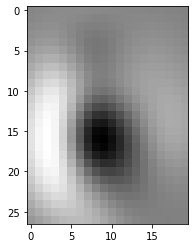

In [ ]:
# Visualized the Displacement Field obtained from BSpline Transform

import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')